In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-train/Face_Train/140_y_f_h_b.jpg
/kaggle/input/face-train/Face_Train/116_m_m_s_a.jpg
/kaggle/input/face-train/Face_Train/066_y_m_h_a.jpg
/kaggle/input/face-train/Face_Train/004_o_m_a_b.jpg
/kaggle/input/face-train/Face_Train/066_y_m_n_a.jpg
/kaggle/input/face-train/Face_Train/079_o_f_s_b.jpg
/kaggle/input/face-train/Face_Train/079_o_f_n_a.jpg
/kaggle/input/face-train/Face_Train/066_y_m_h_b.jpg
/kaggle/input/face-train/Face_Train/079_o_f_d_b.jpg
/kaggle/input/face-train/Face_Train/079_o_f_a_b.jpg
/kaggle/input/face-train/Face_Train/140_y_f_a_b.jpg
/kaggle/input/face-train/Face_Train/004_o_m_f_a.jpg
/kaggle/input/face-train/Face_Train/004_o_m_d_b.jpg
/kaggle/input/face-train/Face_Train/066_y_m_a_b.jpg
/kaggle/input/face-train/Face_Train/079_o_f_n_b.jpg
/kaggle/input/face-train/Face_Train/079_o_f_f_a.jpg
/kaggle/input/face-train/Face_Train/004_o_m_h_b.jpg
/kaggle/input/face-train/Face_Train/004_o_m_h_a.jpg
/kaggle/input/face-train/Face_Train/004_o_m_s_b.jpg
/kaggle/inpu

In [2]:
import torch
import torchvision
import glob
import numpy
import cv2
import math
import matplotlib.pyplot as plt
from skimage import io
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize

In [3]:
#train and test data directory
data_dir = "/kaggle/input/face-train"
test_data_dir = "/kaggle/input/face-test"

#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))

In [4]:
print(len(dataset))
print(len(test_dataset))

60
12


####Mi estructura

In [5]:
img, label = dataset[0]
print(img.shape,label)
print("Clases del dataset : \n",dataset.classes)

torch.Size([3, 150, 150]) 0
Clases del dataset : 
 ['Face_Train']


Label : Face_Train


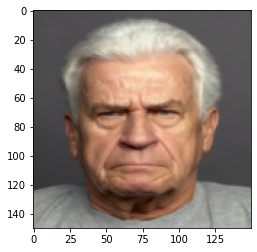

In [6]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*dataset[1])

In [7]:
batch_size = 256
val_size = 12
train_size = len(dataset) - val_size 
train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Tamano del train : {len(train_data)}")
print(f"Tamano de la validacion : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

Tamano del train : 48
Tamano de la validacion : 12


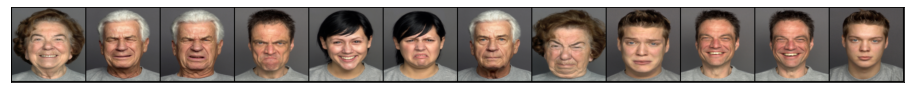

In [8]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(val_dl)

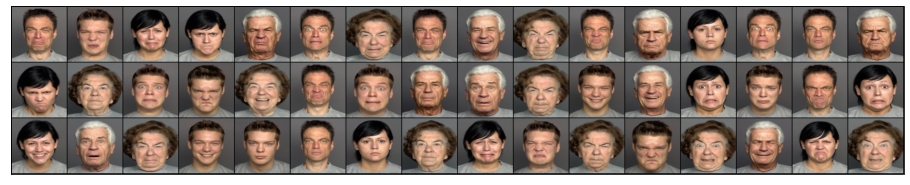

In [9]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [22]:
num_classes = 10

class CNNAlex(CNN):
    def __init__(self,num_classes=10):
        super(CNNAlex, self).__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
            
        )
        
    def forward(self, xb):
        return self.network(xb)

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    
    history = []
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


In [33]:
num_epochs = 20
learning_rate = 0.00001
model = CNNResnet(num_classes)
opt_func = torch.optim.Adam(model.parameters(), lr = learning_rate)

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7785, val_loss: 1.7638, val_acc: 1.0000
Epoch [1], train_loss: 1.7638, val_loss: 1.7530, val_acc: 1.0000
Epoch [2], train_loss: 1.7530, val_loss: 1.7434, val_acc: 1.0000
Epoch [3], train_loss: 1.7434, val_loss: 1.7342, val_acc: 1.0000
Epoch [4], train_loss: 1.7342, val_loss: 1.7254, val_acc: 1.0000
Epoch [5], train_loss: 1.7254, val_loss: 1.7165, val_acc: 1.0000
Epoch [6], train_loss: 1.7165, val_loss: 1.7072, val_acc: 1.0000
Epoch [7], train_loss: 1.7072, val_loss: 1.6976, val_acc: 1.0000
Epoch [8], train_loss: 1.6976, val_loss: 1.6879, val_acc: 1.0000
Epoch [9], train_loss: 1.6879, val_loss: 1.6778, val_acc: 1.0000
Epoch [10], train_loss: 1.6777, val_loss: 1.6670, val_acc: 1.0000
Epoch [11], train_loss: 1.6669, val_loss: 1.6554, val_acc: 1.0000
Epoch [12], train_loss: 1.6554, val_loss: 1.6432, val_acc: 1.0000
Epoch [13], train_loss: 1.6432, val_loss: 1.6301, val_acc: 1.0000
Epoch [14], train_loss: 1.6301, val_loss: 1.6163, val_acc: 1.0000
Epoch [15], train_lo

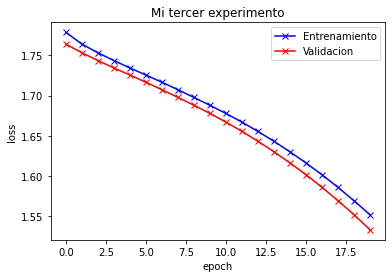

In [35]:
def plot_grap(history):
    #accuracies = [x['val_acc'] for x in history]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    #plt.plot(accuracies, '-x')
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Entrenamiento','Validacion'])
    plt.title('Mi tercer experimento');

plot_grap(history)